In [37]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt


# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['disneyland','tokyo','disney', 'im', 'tdrnow','paris','california','amp','disneysea','got',
                 'ºc', 'ºf', 'ºoº','𝗧𝗵𝗲','くまのプーさん', 'ディズニー', 'ディズニーシー','ディズニーハロウィーン',
                 'ディズニーランド', 'ディズニー好きと繋がりたい', 'フェスティバルオブミスティーク', 'マルマン',
                 'ㅋㅋㅋ', '場所', '更新', '月released', '東京ディズニーシー', '東京ディズニーランド', '東京ディズニーリゾート',
                 '香港迪士尼樂園', 'ºº', 'hong', 'kong',"disneylandresort", "disneyland", "disneyresort",
                  "californiaadventure",'downtowndisney','disneyanaheim','disneylandanaheim',
                  'disneycalifornia','californiadisney','disneysea', 'disneytokyo', 'disneytokyoresort', 
                  'tokyodisney','tokyodisneyresort', 'tokyodisneyland','東京ディズニーランド', 'ディズニーランド',
                  '東京ディズニーシー', 'ズニーシー', 'tdr_now', 'tdr_md','tdr','dca','dl', 'wdw','disneylandparis',
                  'theme_park', 'min', 'day', 'new', 'guy', 'year', 'way', 'part', 'thing', 'man','ティスニー',
                  'side', 'sia', 'ティスニーラント', 'ティスニーハロウィーン', 'today', 'wanna', 'place',
                  'world', 'disneyworld', 'next', 'disneypark', '東京ティスニーシー', 'yen',
                  '東京ティスニーラント', 'land', 'park', 'ティスニーシー', 'tdl', 'tdrmd', 'lot',
                  "東京ティスニーリソート"])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [38]:
df = pd.read_json('DiSmldata.json')

In [39]:
df_en_neg = df[(df['label'] == 3)]

In [40]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df_en_neg.clean_text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['galaxys', 'edge', 'walt', 'disney', 'world', 'isnt', 'failure', 'like', 'disneyland', 'its', 'underperforming', 'but', 'set', 'fail', 'opening', 'rise', 'land', 'mickeys', 'runaway', 'railway', 'open', 'people', 'holding', 'back', 'how', 'many', 'who', 'knows']]


In [41]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=20) # higher threshold fewer phrases. Must show up more than 2 times the phrases 
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [42]:
data_ready[0:10]

[['galaxys_edge',
  'walt',
  'failure',
  'underperforming',
  'set',
  'fail',
  'open',
  'rise',
  'mickey',
  'runaway_railway',
  'open',
  'people',
  'hold',
  'back',
  'many',
  'know'],
 ['bitch', 'want'],
 ['ready', 'heart_broken'],
 ['ask',
  'tomorrowland',
  'space',
  'horizon',
  'wall',
  'dark',
  'ride',
  'reroute',
  'monorail',
  'rework',
  'tron',
  'electronica',
  'end',
  'line',
  'bar',
  'people_mover',
  'hyperionlite',
  'theater',
  'astro_orbitor',
  'remember'],
 ['want', 'miss', 'almost', 'go', 'last', 'season', 'september', 'resort'],
 ['stop', 'tweet', 'much', 'miss'],
 ['chetta', 'wrong', 'photo', 'chacha', 'moscow', 'precise'],
 ['miss'],
 ['fuck', 'miss'],
 ['talk',
  'hard',
  'open',
  'shanghai',
  'pulse',
  'nightclub',
  'shoot',
  'work',
  'politician',
  'father',
  'view',
  'host',
  'get',
  'include',
  'ambassador',
  'china']]

In [43]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [44]:
#3 Topics
lda_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [45]:
pprint(lda_model3.print_topics())

[(0,
  '0.040*"go" + 0.026*"get" + 0.023*"fuck" + 0.019*"see" + 0.019*"miss" + '
  '0.016*"want" + 0.014*"take" + 0.013*"bad" + 0.010*"say" + 0.010*"really"'),
 (1,
  '0.030*"halloween" + 0.025*"time" + 0.021*"shit" + 0.020*"ill" + 0.012*"sad" '
  '+ 0.012*"haunted_mansion" + 0.011*"ghost" + 0.010*"know" + 0.009*"back" + '
  '0.007*"always"'),
 (2,
  '0.016*"ride" + 0.014*"still" + 0.014*"make" + 0.011*"think" + 0.009*"cry" + '
  '0.008*"would" + 0.008*"let" + 0.008*"tell" + 0.007*"look" + 0.007*"name"')]


In [46]:
#4 Topics
lda_model4 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [47]:
pprint(lda_model4.print_topics())

[(0,
  '0.037*"get" + 0.033*"fuck" + 0.028*"see" + 0.026*"miss" + 0.023*"want" + '
  '0.018*"bad" + 0.014*"say" + 0.014*"people" + 0.012*"week" + 0.010*"always"'),
 (1,
  '0.042*"halloween" + 0.020*"take" + 0.015*"ghost" + 0.015*"know" + '
  '0.012*"back" + 0.010*"look" + 0.010*"name" + 0.010*"cold" + 0.009*"also" + '
  '0.009*"wear"'),
 (2,
  '0.050*"go" + 0.020*"ride" + 0.017*"still" + 0.017*"make" + 0.015*"sad" + '
  '0.014*"think" + 0.012*"really" + 0.011*"cry" + 0.010*"would" + '
  '0.009*"tell"'),
 (3,
  '0.035*"time" + 0.030*"shit" + 0.028*"ill" + 0.017*"haunted_mansion" + '
  '0.011*"let" + 0.010*"kid" + 0.010*"little" + 0.009*"wrong" + '
  '0.009*"hauntedmansion" + 0.009*"damn"')]


In [48]:
#5 Topics
lda_model5 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [49]:
pprint(lda_model5.print_topics())

[(0,
  '0.062*"go" + 0.040*"get" + 0.036*"fuck" + 0.029*"miss" + 0.026*"want" + '
  '0.020*"bad" + 0.016*"say" + 0.015*"people" + 0.013*"week" + 0.011*"look"'),
 (1,
  '0.048*"halloween" + 0.032*"ill" + 0.025*"ride" + 0.017*"know" + '
  '0.014*"back" + 0.012*"tell" + 0.012*"always" + 0.010*"never" + 0.010*"try" '
  '+ 0.009*"ticket"'),
 (2,
  '0.049*"time" + 0.028*"take" + 0.021*"ghost" + 0.016*"let" + 0.014*"cold" + '
  '0.013*"little" + 0.013*"wrong" + 0.012*"damn" + 0.011*"trip" + 0.011*"use"'),
 (3,
  '0.040*"shit" + 0.038*"see" + 0.023*"sad" + 0.022*"haunted_mansion" + '
  '0.013*"kid" + 0.013*"life" + 0.013*"also" + 0.013*"wear" + '
  '0.012*"hauntedmansion" + 0.011*"girl"'),
 (4,
  '0.025*"still" + 0.025*"make" + 0.020*"think" + 0.019*"really" + 0.017*"cry" '
  '+ 0.015*"would" + 0.014*"complain" + 0.013*"name" + 0.011*"maybe" + '
  '0.010*"forget"')]


In [50]:
#6 Topics
lda_model6 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [51]:
pprint(lda_model6.print_topics())

[(0,
  '0.080*"go" + 0.047*"fuck" + 0.037*"miss" + 0.033*"want" + 0.026*"bad" + '
  '0.020*"say" + 0.017*"week" + 0.015*"complain" + 0.013*"hard" + '
  '0.013*"kill"'),
 (1,
  '0.034*"make" + 0.028*"think" + 0.026*"really" + 0.023*"cry" + 0.021*"would" '
  '+ 0.020*"let" + 0.017*"wrong" + 0.015*"maybe" + 0.013*"forget" + '
  '0.013*"die"'),
 (2,
  '0.054*"get" + 0.033*"ride" + 0.020*"people" + 0.016*"tell" + 0.015*"always" '
  '+ 0.015*"look" + 0.013*"never" + 0.013*"could" + 0.011*"definitely" + '
  '0.011*"long"'),
 (3,
  '0.042*"shit" + 0.040*"see" + 0.028*"still" + 0.024*"sad" + '
  '0.023*"haunted_mansion" + 0.014*"cold" + 0.014*"kid" + 0.014*"life" + '
  '0.014*"also" + 0.013*"wear"'),
 (4,
  '0.038*"take" + 0.029*"ghost" + 0.019*"name" + 0.015*"trip" + 0.014*"line" + '
  '0.013*"dlr" + 0.012*"buy" + 0.011*"remember" + 0.011*"adventure" + '
  '0.010*"literally"'),
 (5,
  '0.066*"halloween" + 0.055*"time" + 0.044*"ill" + 0.023*"know" + '
  '0.019*"back" + 0.015*"little" + 0.014*"t

In [52]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model3, corpus, dictionary=lda_model3.id2word)
vis

/Users/justin/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.208199  0.148892       1        1  37.204628
2      0.033626 -0.243255       2        1  33.443047
1     -0.241825  0.094363       3        1  29.352325, topic_info=      Category         Freq       Term        Total  loglift  logprob
40     Default  1221.000000         go  1221.000000  30.0000  30.0000
74     Default   727.000000  halloween   727.000000  29.0000  29.0000
59     Default   794.000000        get   794.000000  28.0000  28.0000
156    Default   600.000000       time   600.000000  27.0000  27.0000
55     Default   719.000000       fuck   719.000000  26.0000  26.0000
...        ...          ...        ...          ...      ...      ...
2016    Topic3    89.001663     parade    89.656715   1.2185  -5.6093
1410    Topic3    82.951241      happy    83.614258   1.2178  -5.6797
874     Topic3   129.529739     happen   130.581833   1.2177  -5.2340
148     Topic3   163.750702     little   165.656296   1.2142  -4.9996
12688   Topic3   110.510269     hayden   115.693008   1.1800  -5.3928

[130 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
233       1  0.993590   actually
350       3  0.990659  adventure
82        2  0.006030       also
82        3  0.994988       also
677       3  0.994883     always
...     ...       ...        ...
563       3  0.997080       wear
226       1  0.997470       week
243       2  0.997704      would
54        2  0.993968      wrong
178       2  0.997743        wtf

[118 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [53]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model6, corpus, dictionary=lda_model6.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.327173 -0.093665       1        1  19.418808
2      0.135178 -0.166053       2        1  19.068304
5      0.059723 -0.009760       3        1  16.301664
3     -0.004209  0.314228       4        1  15.845463
1      0.111125 -0.060138       5        1  15.483459
4      0.025355  0.015389       6        1  13.882301, topic_info=     Category         Freq             Term        Total  loglift  logprob
40    Default  1283.000000               go  1283.000000  30.0000  30.0000
74    Default   894.000000        halloween   894.000000  29.0000  29.0000
59    Default   851.000000              get   851.000000  28.0000  28.0000
156   Default   738.000000             time   738.000000  27.0000  27.0000
55    Default   755.000000             fuck   755.000000  26.0000  26.0000
...       ...          ...              ...          ...      ...      ...
1482   Topic6    60.279842  ariels_undersea    61.057587   1.9617  -5.2502
1488   Topic6    59.640522   silly_symphony    60.418266   1.9616  -5.2608
1376   Topic6    56.969154            racer    57.747410   1.9610  -5.3066
584    Topic6    67.077843           summer    68.423203   1.9547  -5.1433
3530   Topic6    67.644791            ocean    79.798119   1.8093  -5.1349

[228 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
658       2  0.099271    account
658       5  0.893443    account
233       2  0.993362   actually
350       6  0.991580  adventure
656       5  0.996636        ago
...     ...       ...        ...
95        4  0.993987      whole
70        2  0.993662       work
243       5  0.998362      would
54        5  0.997405      wrong
178       2  0.997694        wtf

[223 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 6, 4, 2, 5])

In [54]:
#10 Topics
lda_model10 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=20,
                                           per_word_topics=True)

In [55]:
pprint(lda_model10.print_topics())

[(0,
  '0.128*"go" + 0.078*"time" + 0.063*"ill" + 0.025*"let" + 0.022*"life" + '
  '0.018*"maybe" + 0.017*"instead" + 0.016*"blizzcon" + 0.015*"tomorrow" + '
  '0.013*"last"'),
 (1,
  '0.074*"fuck" + 0.059*"miss" + 0.045*"take" + 0.042*"make" + 0.040*"bad" + '
  '0.034*"ghost" + 0.032*"say" + 0.023*"look" + 0.020*"kill" + 0.018*"call"'),
 (2,
  '0.071*"ride" + 0.033*"tell" + 0.030*"hard" + 0.023*"line" + 0.023*"mean" + '
  '0.023*"dlr" + 0.019*"even" + 0.018*"ask" + 0.018*"adventure" + '
  '0.017*"anakin"'),
 (3,
  '0.075*"get" + 0.048*"want" + 0.035*"sad" + 0.025*"week" + 0.021*"always" + '
  '0.020*"cold" + 0.018*"never" + 0.017*"bitch" + 0.015*"happen" + '
  '0.015*"definitely"'),
 (4,
  '0.040*"cry" + 0.036*"would" + 0.032*"complain" + 0.031*"name" + '
  '0.025*"girl" + 0.022*"die" + 0.021*"couple" + 0.019*"put" + '
  '0.018*"remember" + 0.018*"month"'),
 (5,
  '0.081*"halloween" + 0.028*"know" + 0.027*"people" + 0.023*"back" + '
  '0.018*"also" + 0.018*"wear" + 0.017*"try" + 0.016

In [56]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model10, corpus, dictionary=lda_model10.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.227096 -0.328695       1        1  15.966527
1      0.002193  0.077177       2        1  15.107844
5      0.290302  0.256149       3        1  14.975988
0     -0.013021 -0.008936       4        1  12.904708
6     -0.062003  0.004662       5        1  12.219213
2     -0.118770 -0.002123       6        1  10.522725
4     -0.094577 -0.005881       7        1   9.313642
9     -0.098691  0.000421       8        1   5.802106
7     -0.066264  0.003613       9        1   1.593622
8     -0.066264  0.003613      10        1   1.593622, topic_info=      Category         Freq        Term        Total  loglift  logprob
40     Default  1365.000000          go  1365.000000  30.0000  30.0000
74     Default  1000.000000   halloween  1000.000000  29.0000  29.0000
59     Default   990.000000         get   990.000000  28.0000  28.0000
55     Default   927.000000        fuck   927.000000  27.0000  27.0000
156    Default   839.000000        time   839.000000  26.0000  26.0000
...        ...          ...         ...          ...      ...      ...
2102   Topic10     0.100591       knott     1.327001   1.5595  -9.4813
13028  Topic10     0.100591         ack     1.326986   1.5596  -9.4813
2044   Topic10     0.100585  lightsaber    34.648392  -1.7028  -9.4813
8117   Topic10     0.100582      banana     1.311503   1.5712  -9.4813
13005  Topic10     0.100582       aging     1.311230   1.5714  -9.4813

[889 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
658       2  0.990060    account
658       3  0.008049    account
233       2  0.994893   actually
350       6  0.993077  adventure
1889      7  0.983482        age
...     ...       ...        ...
1226      8  0.983365     wonder
70        8  0.989384       work
243       7  0.995100      would
54        5  0.994314      wrong
178       4  0.995253        wtf

[270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 6, 1, 7, 3, 5, 10, 8, 9])

In [57]:
#6 topics seem to make the most coherent sense

In [58]:
#Final Model 


#6 Topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=777,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                            per_word_topics=True)

In [59]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.5140,"halloween, time, ill, know, back, always, cold...","[galaxys_edge, walt, failure, underperforming,..."
1,1,0.0,0.3889,"go, get, fuck, see, want, people, week, name, ...","[bitch, want]"
2,2,5.0,0.6423,"halloween, time, ill, know, back, always, cold...","[ready, heart_broken]"
3,3,4.0,0.7377,"ride, tell, ticket, instead, line, mean, dlr, ...","[ask, tomorrowland, space, horizon, wall, dark..."
4,4,0.0,0.4640,"go, get, fuck, see, want, people, week, name, ...","[want, miss, almost, go, last, season, septemb..."
5,5,0.0,0.6333,"go, get, fuck, see, want, people, week, name, ...","[stop, tweet, much, miss]"
6,6,1.0,0.4558,"miss, take, bad, say, look, wrong, kill, call,...","[chetta, wrong, photo, chacha, moscow, precise]"
7,7,1.0,0.5833,"miss, take, bad, say, look, wrong, kill, call,...",[miss]
8,8,1.0,0.3889,"miss, take, bad, say, look, wrong, kill, call,...","[fuck, miss]"
9,9,0.0,0.6648,"go, get, fuck, see, want, people, week, name, ...","[talk, hard, open, shanghai, pulse, nightclub,..."


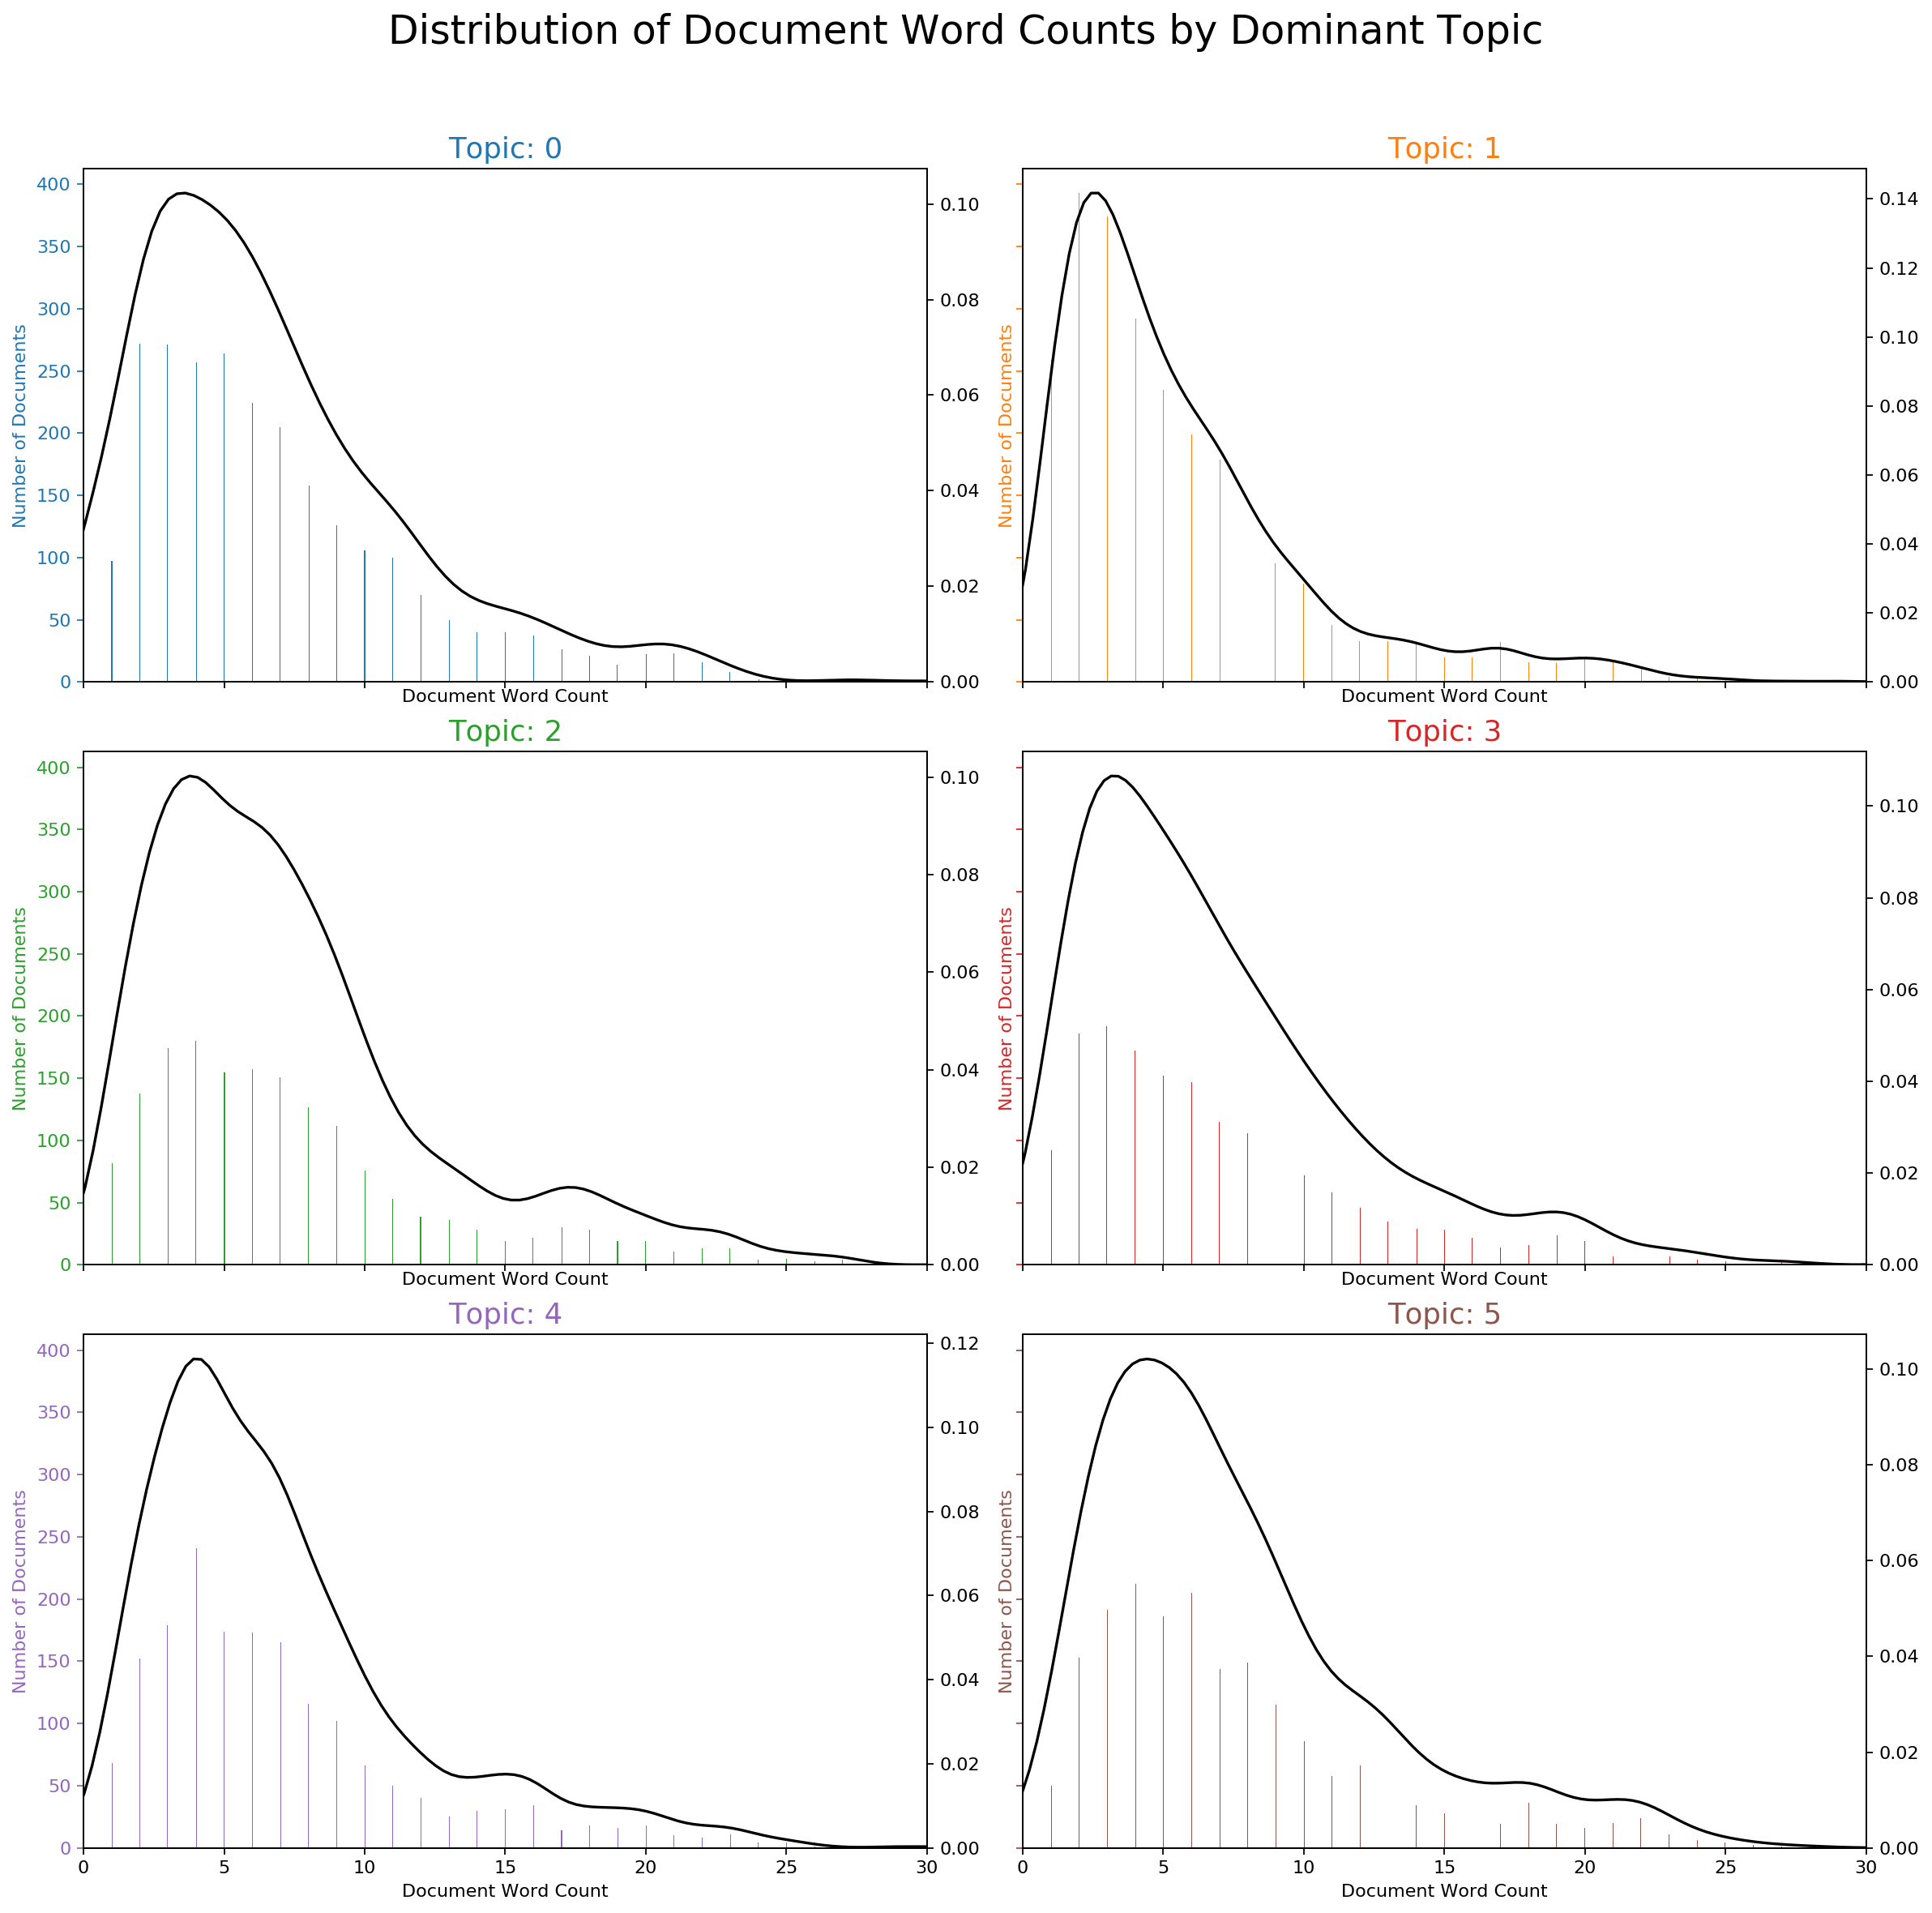

In [61]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(3,2,figsize=(15,15), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 30), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

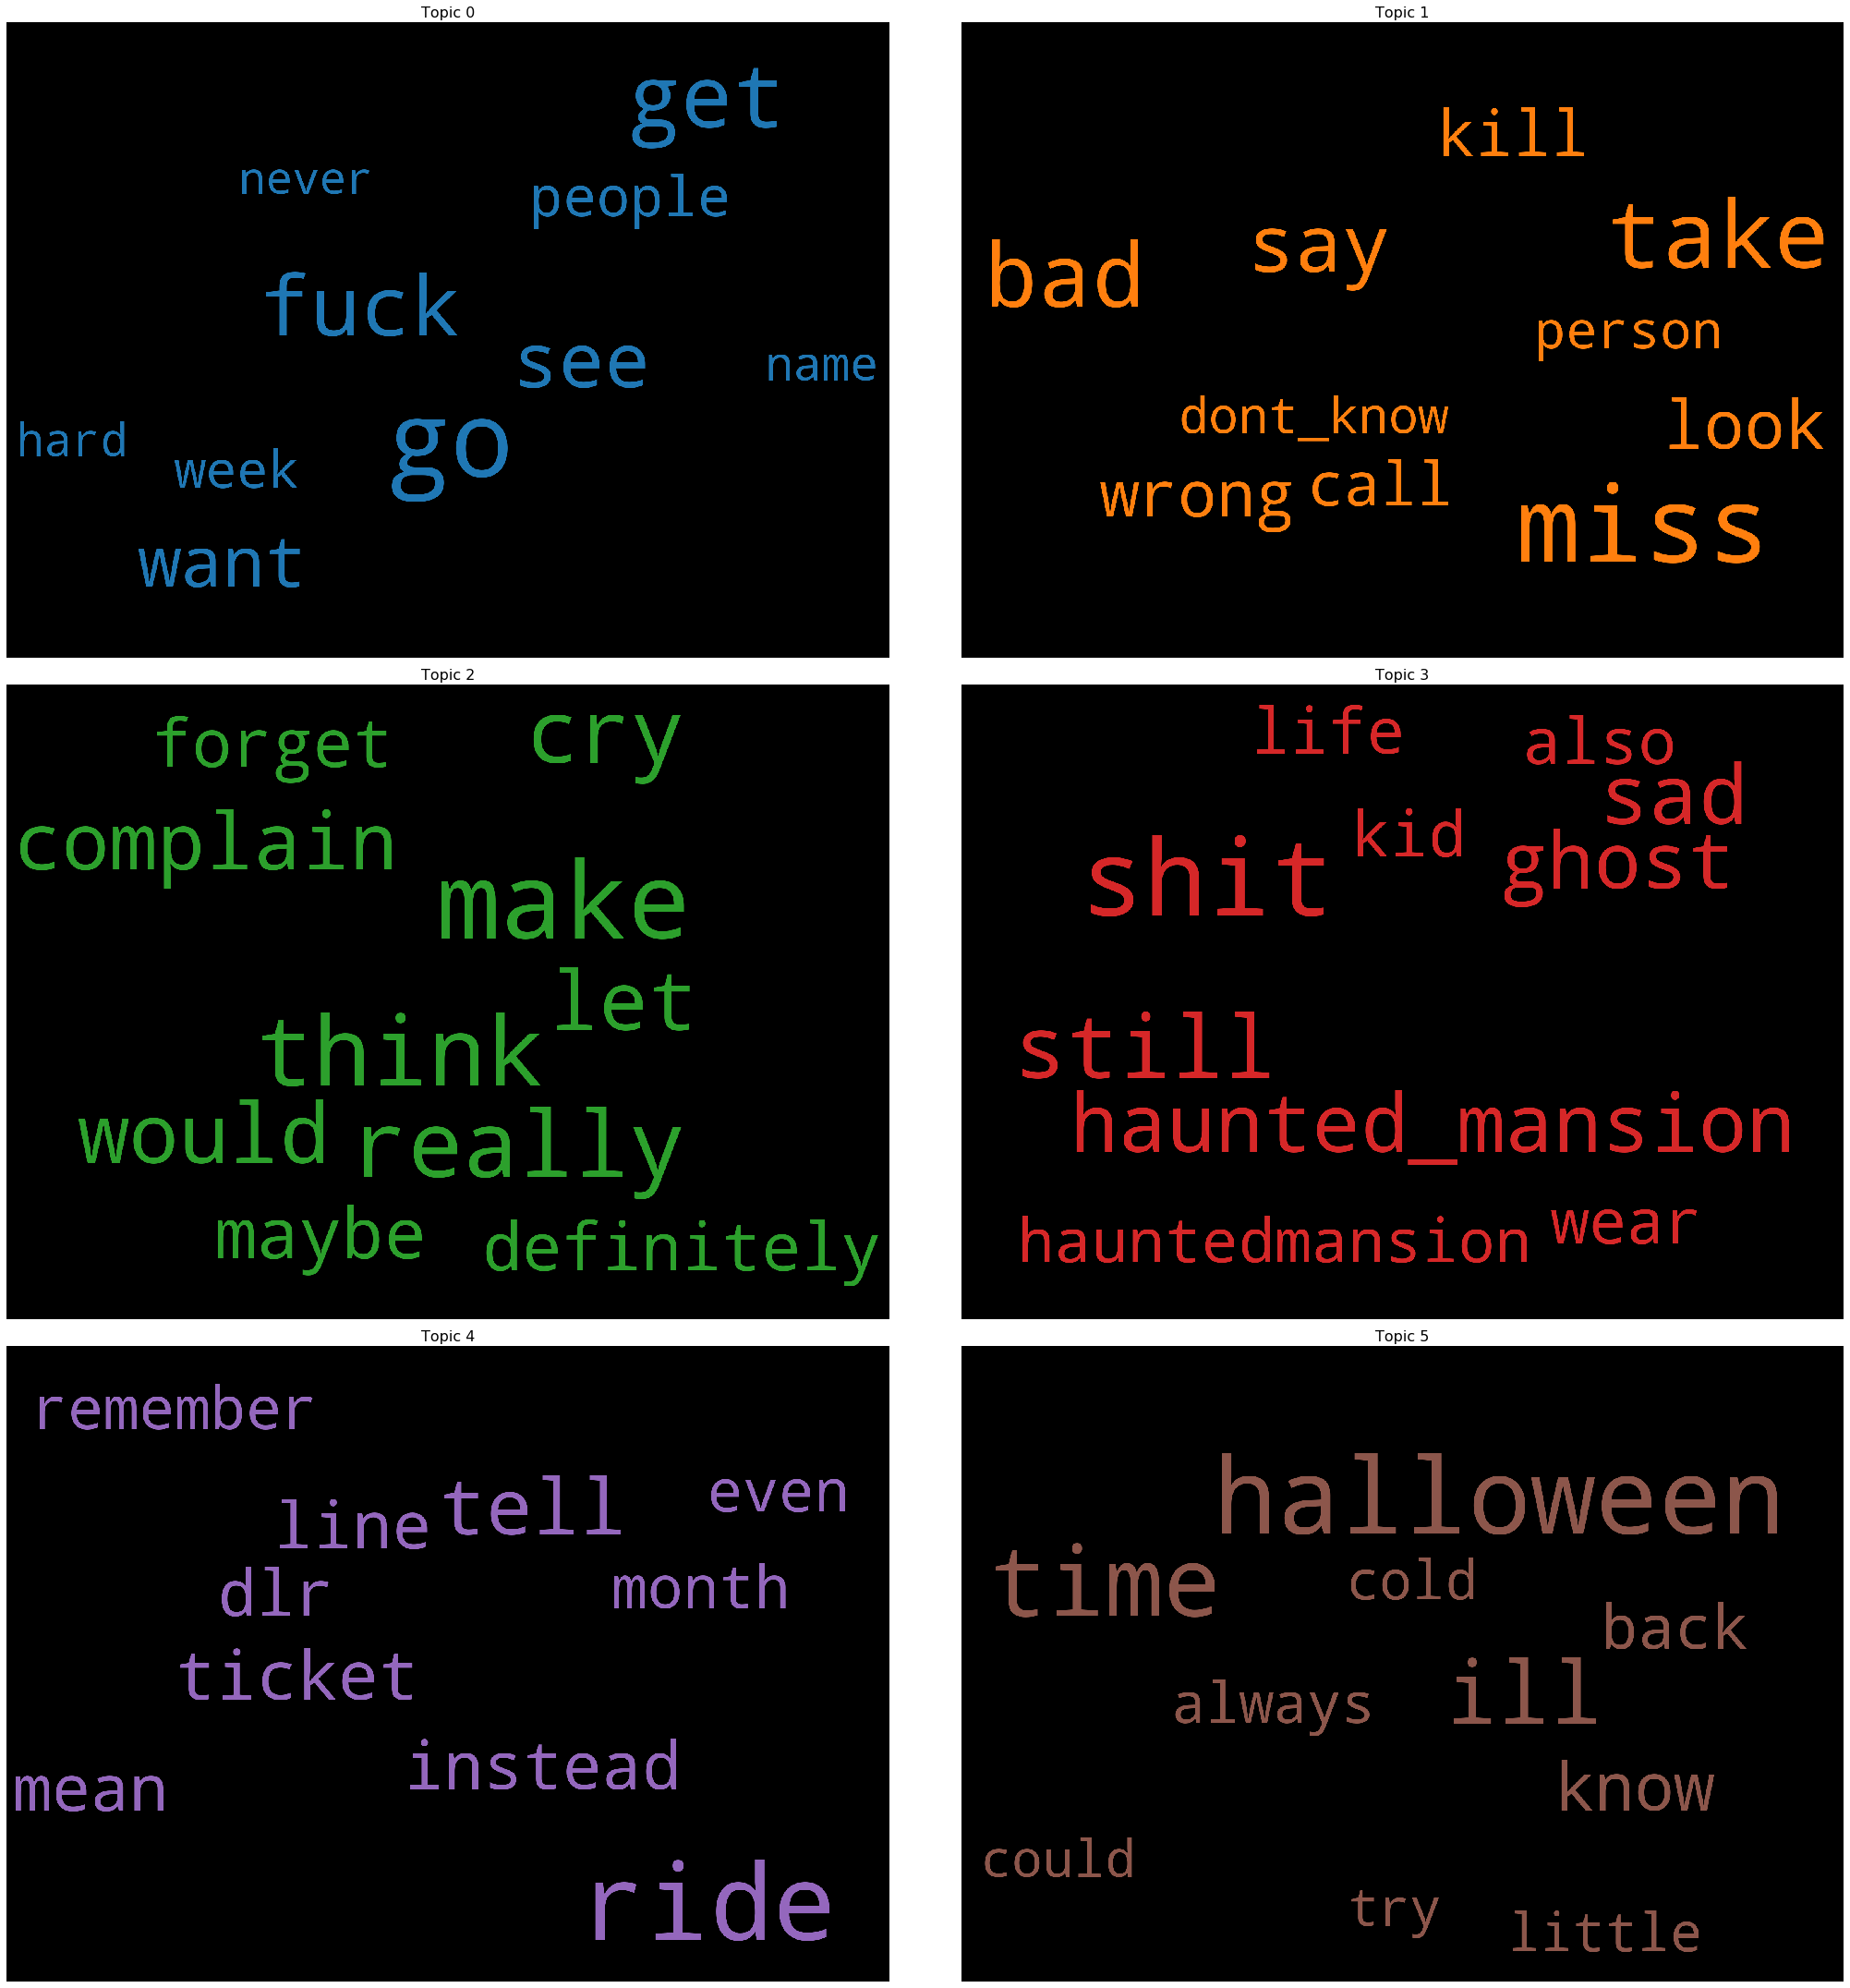

In [62]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='black',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(30,30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

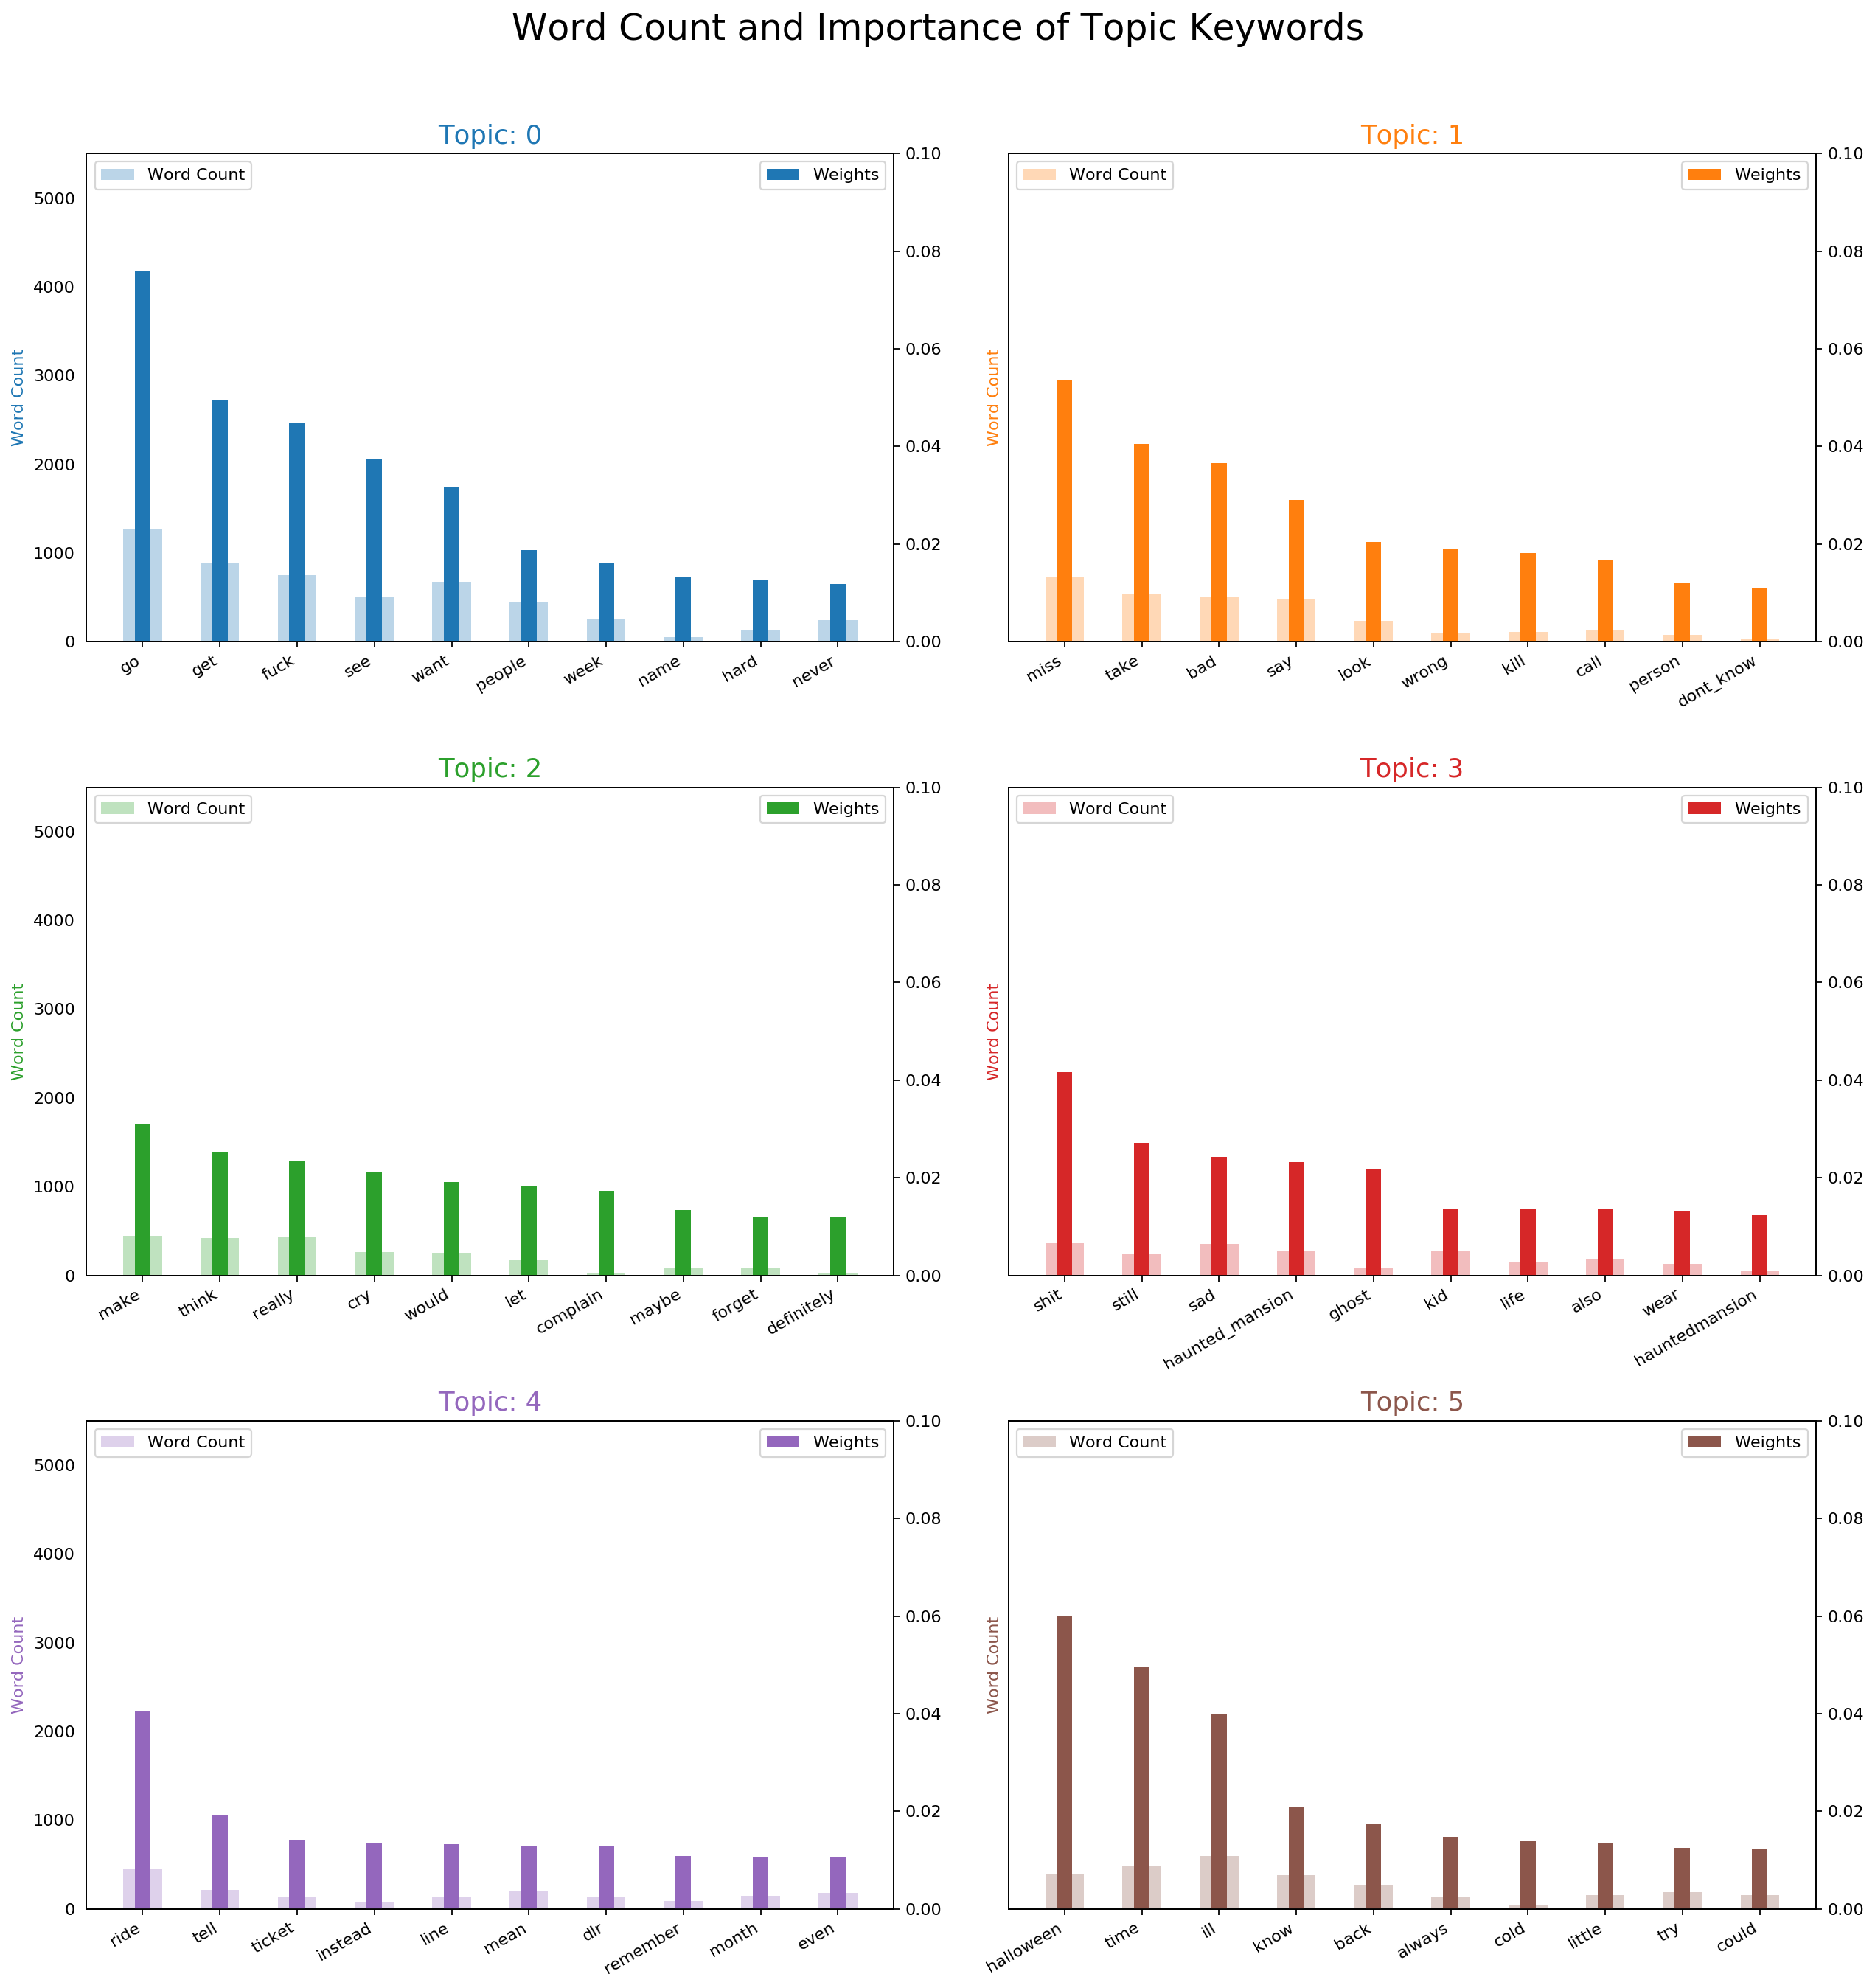

In [63]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 5500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [64]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

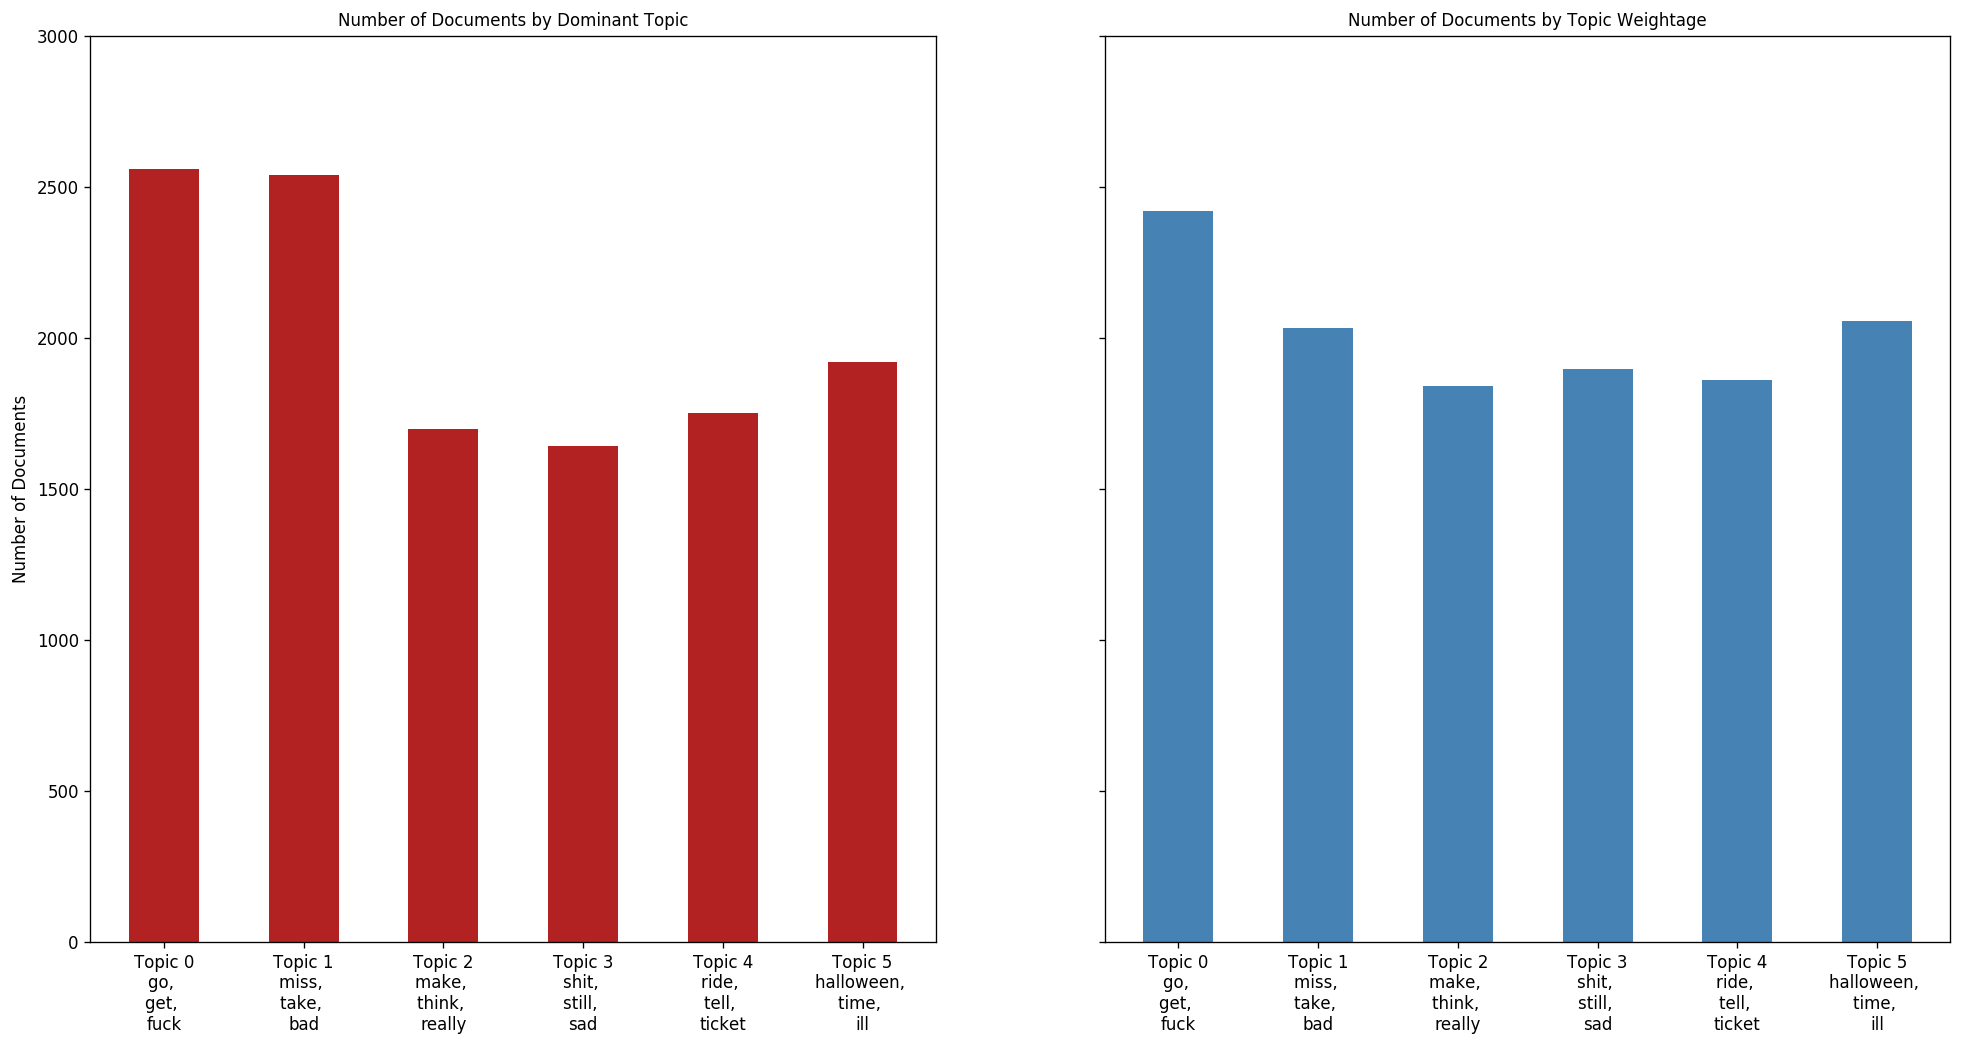

In [66]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 3000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [67]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state= 77, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9327 samples in 0.004s...
[t-SNE] Computed neighbors for 9327 samples in 0.311s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9327
[t-SNE] Computed conditional probabilities for sample 2000 / 9327
[t-SNE] Computed conditional probabilities for sample 3000 / 9327
[t-SNE] Computed conditional probabilities for sample 4000 / 9327
[t-SNE] Computed conditional probabilities for sample 5000 / 9327
[t-SNE] Computed conditional probabilities for sample 6000 / 9327
[t-SNE] Computed conditional probabilities for sample 7000 / 9327
[t-SNE] Computed conditional probabilities for sample 8000 / 9327
[t-SNE] Computed conditional probabilities for sample 9000 / 9327
[t-SNE] Computed conditional probabilities for sample 9327 / 9327
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.794403
[t-SNE] KL divergence after 1000 iterations: 0.797069


In [68]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [69]:
num_topics = 6
topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

go                   0.076
get                  0.049
fuck                 0.045
see                  0.037
want                 0.032
people               0.019
week                 0.016
name                 0.013
hard                 0.013
never                0.012
Topic 1 |---------------------

miss                 0.054
take                 0.041
bad                  0.037
say                  0.029
look                 0.021
wrong                0.019
kill                 0.018
call                 0.017
person               0.012
dont_know            0.011
Topic 2 |---------------------

make                 0.031
think                0.025
really               0.023
cry                  0.021
would                0.019
let                  0.018
complain             0.017
maybe                0.013
forget               0.012
definitely           0.012
Topic 3 |---------------------

shit                 0.042
sti

In [70]:
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 6
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700,tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave")
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

show(plot)

Loading BokehJS ...

In [71]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/justin/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.340290  0.040998       1        1  19.972326
5     -0.129240  0.179811       2        1  17.814787
2     -0.063758  0.085186       3        1  15.688623
3     -0.048522 -0.310170       4        1  15.639474
4     -0.055780  0.011873       5        1  15.590292
1     -0.042991 -0.007699       6        1  15.294501, topic_info=     Category         Freq       Term        Total  loglift  logprob
40    Default  1256.000000         go  1256.000000  30.0000  30.0000
74    Default   886.000000  halloween   886.000000  29.0000  29.0000
59    Default   817.000000        get   817.000000  28.0000  28.0000
42    Default   678.000000       miss   678.000000  27.0000  27.0000
156   Default   731.000000       time   731.000000  26.0000  26.0000
...       ...          ...        ...          ...      ...      ...
307    Topic6    71.367073       home    72.127014   1.8671  -5.1782
1502   Topic6    71.111496       evil    71.874092   1.8670  -5.1818
2292   Topic6    69.659447      shirt    70.446587   1.8664  -5.2024
556    Topic6   126.023094       coat   127.478233   1.8662  -4.6096
5003   Topic6    78.787727       flex    90.580261   1.7382  -5.0793

[221 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
658       3  0.990624    account
233       6  0.994384   actually
350       5  0.991603  adventure
656       6  0.992713        ago
431       4  0.993435      alone
...     ...       ...        ...
95        3  0.988194      whole
70        1  0.993561       work
243       3  0.998590      would
54        6  0.996060      wrong
178       1  0.993609        wtf

[205 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 3, 4, 5, 2])